In [52]:
%run "imports.ipynb"

In [53]:
ac_biallel = zarr.open('data/phase2_biallel_allele_count.zarr')
outgroup_allele_counts= zarr.open('data/outgroup_alleles_phase2.zarr')
callset = callset_biallel

In [54]:
contigs = ['2R','2L','3R','3L', 'X']

----------------------------------------------

In [55]:
def pbs(chrom, pop1, pop2, pop3, window_size=100, min_maf=0.02, normed=True):
    
    # load variant positions
    loc_pass_variants = callset[chrom]['variants/FILTER_PASS'][:]
    pos = callset[chrom]['variants/POS'][:][loc_pass_variants]
    
    # load allele counts
    ac1 = allel.AlleleCountsArray(ac_biallel[chrom][pop1])
    ac2 = allel.AlleleCountsArray(ac_biallel[chrom][pop2])
    ac3 = allel.AlleleCountsArray(ac_biallel[chrom][pop3])

    # locate segregating variants at sufficient frequency
    ac = ac1 + ac2 + ac3
    loc_seg = (ac.to_frequencies()[:, :2].min(axis=1) > min_maf)
    pos = pos[loc_seg]
    ac1 = ac1[loc_seg]
    ac2 = ac2[loc_seg]
    ac3 = ac3[loc_seg]
    
    # setup windows
    starts = allel.moving_statistic(pos, statistic=lambda v: v[0], size=window_size)
    starts[0] = 1  # fix to start of sequence
    ends = np.append(starts[1:] - 1, [np.max(pos)])

    # compute pbs
    res = allel.pbs(ac1, ac2, ac3, window_size=window_size, normed=normed)

    return starts, ends, res

def pbs_plot (chrom, pop1, pop2, pop3, window_size=100, min_maf=0.02, normed=True):
    starts, ends, y = pbs(chrom, pop1, pop2, pop3)
    fig, ax = plt.subplots(figsize=(14, 3))
    x = (starts + ends) / 2
    sns.despine(ax=ax, offset=10)
    ax.set_xlim(0, x.max())
    ax.plot(x, y, marker='o', linestyle=' ', mfc='none', mec='k', markersize=2)
    ax.set_xlabel('Genome position (bp)')
    ax.set_ylabel('PBS');
    


def plot_genes_remastered(chrom, pos):
    plot_genes(genome, geneset_fn, chrom, pos-100, pos+100, label=True, label_rotation=90, height=0.5)
    
    
    
    
def locate_genes(chrom, value, pop1, pop2, pop3):    
    col_names = ['seqid', 'source', 'type', 'start', 'end', 'score', 'strand', 'phase', 'attributes']
    df = pd.read_csv('/home/jovyan/notebooks/data/Anopheles-gambiae-PEST_BASEFEATURES_AgamP4.2.sorted.gff3.gz', compression='gzip',
                             sep='\t', comment='#', low_memory=False,
                             header=None, names=col_names)
    
    results = pbs(chrom, pop1, pop2, pop3)
    over30 = results[0][results[2] > value]
    
    df2 = pd.DataFrame([])
    for i in range(len(over30)):
        a=(df[(df.seqid == '3R') & (df.type == 'gene') & (df['start'] <= over30[i]-100) & (df['end'] >= over30[i]+100)])
        
        df2 = df2.append(a)
        df2.drop_duplicates(keep=False,inplace=True)

    log('Found', len(over30), 'SNPs with PBS values above', value, '\n', 'Total genes found:', len(df2))

    return df2



def plot_genes_pbs(chrom, pop1, pop2, pop3):
    results = pbs(chrom, pop1, pop2, pop3)
    over30 = results[0][results[2] > 0.2]
    print (over30)
    for i in range(len(over30)):
        plt.figure()
        plot_genes_remastered(chrom, over30[i])

## PBS by ecotype

Forest vs Sahel vs Island:

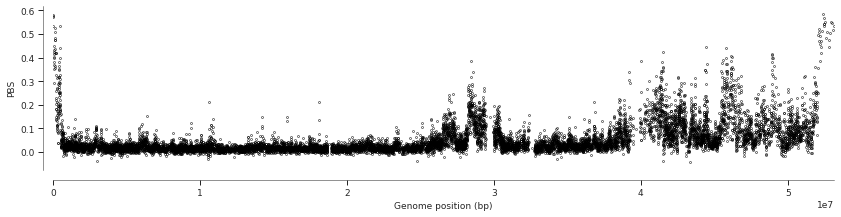

In [56]:
pbs_plot('3R','GHcol', 'BFgam', 'FRgam')

In [57]:
locate_genes('3R', 0.4, 'GHcol', 'BFgam', 'FRgam')

Found 54 SNPs with PBS values above 0.4 
 Total genes found: 15


,seqid,source,type,start,end,score,strand,phase,attributes
119870,3R,VectorBase,gene,57849,62977,.,+,.,ID=AGAP007734;biotype=protein_coding
119891,3R,VectorBase,gene,82151,142545,.,+,.,ID=AGAP007736;biotype=protein_coding
119921,3R,VectorBase,gene,166770,169081,.,+,.,ID=AGAP007738;biotype=protein_coding
119948,3R,VectorBase,gene,174263,175359,.,-,.,ID=AGAP007741;biotype=protein_coding
150130,3R,VectorBase,gene,45808083,45809514,.,+,.,ID=AGAP009945;biotype=protein_coding
150216,3R,VectorBase,gene,46148454,46164104,.,+,.,ID=AGAP009951;biotype=protein_coding
155330,3R,VectorBase,gene,52042711,52059885,.,+,.,ID=AGAP010283;biotype=protein_coding
155349,3R,VectorBase,gene,52067738,52115209,.,+,.,ID=AGAP010286;biotype=protein_coding
155472,3R,VectorBase,gene,52237449,52248062,.,+,.,ID=AGAP010290;biotype=protein_coding
155498,3R,VectorBase,gene,52301006,52349893,.,-,.,ID=AGAP010292;biotype=protein_coding


Mangroves vs Mangroves vs Island:

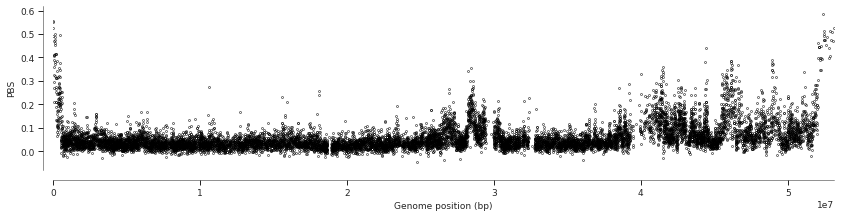

In [47]:
pbs_plot('3R','GHcol', 'GAgam', 'FRgam')

In [58]:
locate_genes('3R', 0.4,'GHcol', 'GAgam', 'FRgam')

Found 39 SNPs with PBS values above 0.4 
 Total genes found: 10


,seqid,source,type,start,end,score,strand,phase,attributes
119870,3R,VectorBase,gene,57849,62977,.,+,.,ID=AGAP007734;biotype=protein_coding
119891,3R,VectorBase,gene,82151,142545,.,+,.,ID=AGAP007736;biotype=protein_coding
119921,3R,VectorBase,gene,166770,169081,.,+,.,ID=AGAP007738;biotype=protein_coding
119971,3R,VectorBase,gene,183531,191944,.,+,.,ID=AGAP007743;biotype=protein_coding
155315,3R,VectorBase,gene,52033775,52038486,.,+,.,ID=AGAP010282;biotype=protein_coding
155498,3R,VectorBase,gene,52301006,52349893,.,-,.,ID=AGAP010292;biotype=protein_coding
155590,3R,VectorBase,gene,52614350,52617318,.,+,.,ID=AGAP010297;biotype=protein_coding
155628,3R,VectorBase,gene,52851999,52854757,.,-,.,ID=AGAP010302;biotype=protein_coding
155659,3R,VectorBase,gene,52951761,52996140,.,+,.,ID=AGAP010304;biotype=protein_coding
155705,3R,VectorBase,gene,53071753,53087640,.,-,.,ID=AGAP010307;biotype=protein_coding


Mangroves vs Mangroves vs Island:

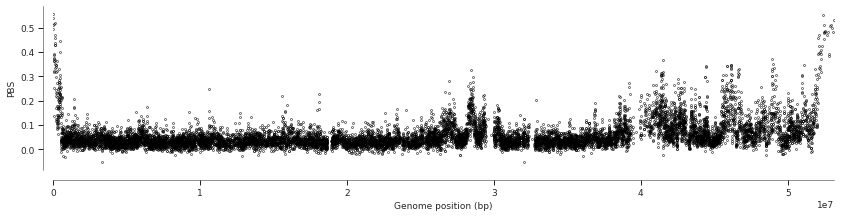

In [49]:
pbs_plot('3R','CIcol', 'GAgam', 'FRgam')

In [59]:
locate_genes('3R',0.4,'CIcol', 'GAgam', 'FRgam')

Found 33 SNPs with PBS values above 0.4 
 Total genes found: 7


,seqid,source,type,start,end,score,strand,phase,attributes
155315,3R,VectorBase,gene,52033775,52038486,.,+,.,ID=AGAP010282;biotype=protein_coding
155349,3R,VectorBase,gene,52067738,52115209,.,+,.,ID=AGAP010286;biotype=protein_coding
155498,3R,VectorBase,gene,52301006,52349893,.,-,.,ID=AGAP010292;biotype=protein_coding
155544,3R,VectorBase,gene,52418651,52422892,.,-,.,ID=AGAP010294;biotype=protein_coding
155554,3R,VectorBase,gene,52457332,52554377,.,-,.,ID=AGAP010295;biotype=protein_coding
155659,3R,VectorBase,gene,52951761,52996140,.,+,.,ID=AGAP010304;biotype=protein_coding
155705,3R,VectorBase,gene,53071753,53087640,.,-,.,ID=AGAP010307;biotype=protein_coding


-------------------------------------